In [30]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix, roc_auc_score,precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE, SMOTENC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap
import mlflow

In [2]:
%pip install imbalanced-learn lightgbm shap


Note: you may need to restart the kernel to use updated packages.


In [8]:
#setting ml flow expoerminet
mlflow.set_experiment("Random-Forest-Model")

<Experiment: artifact_location='file:///D:/INTERN/INTERN/Amnil%20Internship/mlruns/590490615380055142', creation_time=1759669432259, experiment_id='590490615380055142', last_update_time=1759669432259, lifecycle_stage='active', name='Random-Forest-Model', tags={}>

In [9]:
#dataset loading and dataset study
df = pd.read_csv(r'carddata.csv')  
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
print(df.describe())
print("Dataset info",df.info())



Shape of dataset: (1296675, 24)

Data types:
 Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
merch_zipcode            float64
dtype: object

Missing values per column:
 Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant               

In [12]:
print("\nTarget distribution:\n",df['is_fraud'].value_counts())
#shows more is legit transaction and only 1000s are fraud
#and shows data imbalance


Target distribution:
 is_fraud
0    1289169
1       7506
Name: count, dtype: int64


In [13]:
print("\nTarget distribution (normalized):\n", df['is_fraud'].value_counts(normalize=True))


Target distribution (normalized):
 is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


In [14]:
#Dropping unnecessary columns
cols_to_drop = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'trans_num']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print("Columns after removal:", df.columns)

Columns after removal: Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'gender',
       'state', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')


In [15]:
print("Dataset info",df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   state                  1296675 non-null  object 
 6   lat                    1296675 non-null  float64
 7   long                   1296675 non-null  float64
 8   city_pop               1296675 non-null  int64  
 9   job                    1296675 non-null  object 
 10  unix_time              1296675 non-null  int64  
 11  merch_lat              1296675 non-null  float64
 12  merch_long             1296675 non-null  float64
 13  is_fraud               1296675 non-null  int64  
 14  merch_zipcode     

In [16]:
#substituting the missing values in merch zipcode with medan
df['merch_zipcode']=df['merch_zipcode'].fillna(df['merch_zipcode'].median())
print(df.isna().sum())

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
gender                   0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
merch_zipcode            0
dtype: int64


In [17]:

print(df.describe())

                amt           lat          long      city_pop     unix_time  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   7.035104e+01  3.853762e+01 -9.022634e+01  8.882444e+04  1.349244e+09   
std    1.603160e+02  5.075808e+00  1.375908e+01  3.019564e+05  1.284128e+07   
min    1.000000e+00  2.002710e+01 -1.656723e+02  2.300000e+01  1.325376e+09   
25%    9.650000e+00  3.462050e+01 -9.679800e+01  7.430000e+02  1.338751e+09   
50%    4.752000e+01  3.935430e+01 -8.747690e+01  2.456000e+03  1.349250e+09   
75%    8.314000e+01  4.194040e+01 -8.015800e+01  2.032800e+04  1.359385e+09   
max    2.894890e+04  6.669330e+01 -6.795030e+01  2.906700e+06  1.371817e+09   

          merch_lat    merch_long      is_fraud  merch_zipcode  
count  1.296675e+06  1.296675e+06  1.296675e+06   1.296675e+06  
mean   3.853734e+01 -9.022646e+01  5.788652e-03   4.667979e+04  
std    5.109788e+00  1.377109e+01  7.586269e-02   2.380438e+04  
min    1.902779e+01 -1.66671

In [18]:
# Ensure datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extracting hour
df['trans_hour'] = df['trans_date_trans_time'].dt.hour

# Hour conversion to time of day,night,evening
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'day'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

# Time conversion
df['trans_time_of_day'] = df['trans_hour'].apply(time_of_day)
df['trans_time_of_day'] = df['trans_time_of_day'].astype('category')

# Checking the new column
print(df[['trans_date_trans_time','trans_hour','trans_time_of_day']].head(200))
df.info()

    trans_date_trans_time  trans_hour trans_time_of_day
0     2019-01-01 00:00:18           0             night
1     2019-01-01 00:00:44           0             night
2     2019-01-01 00:00:51           0             night
3     2019-01-01 00:01:16           0             night
4     2019-01-01 00:03:06           0             night
..                    ...         ...               ...
195   2019-01-01 02:23:41           2             night
196   2019-01-01 02:26:14           2             night
197   2019-01-01 02:26:16           2             night
198   2019-01-01 02:27:58           2             night
199   2019-01-01 02:28:24           2             night

[200 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   mer

In [19]:
#Amount binning
# Simple 4-bin approach based on quartiles
df['amt_bin'] = pd.qcut(df['amt'], 4, labels=['low', 'medium', 'high', 'very_high'])

# Checking transactions in each bin
print(df['amt_bin'].value_counts())


amt_bin
low          324325
high         324151
very_high    324112
medium       324087
Name: count, dtype: int64


In [20]:
#Separating fraud and non-fraud transactions
fraud_df = df[df['is_fraud'] == 1]
nonfraud_df = df[df['is_fraud'] == 0]

n_nonfraud = 100000 - len(fraud_df)  # ~92,500

#Random sampling of non-fraud rows
nonfraud_sampled = nonfraud_df.sample(n=n_nonfraud, random_state=42)

#Combining all fraud and non-fraud rows
df_small = pd.concat([fraud_df, nonfraud_sampled])

#Shuffle dataset
df_small = df_small.sample(frac=1, random_state=42).reset_index(drop=True)

#Checking target distribution
print(df_small['is_fraud'].value_counts())


is_fraud
0    92494
1     7506
Name: count, dtype: int64


In [21]:
#Target column
y = df_small['is_fraud']

#Features (drop target)
X = df_small.drop(columns=['is_fraud'])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train = X_train.drop(columns=['trans_date_trans_time'])
X_test = X_test.drop(columns=['trans_date_trans_time'])
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Fraud distribution in train:\n", y_train.value_counts())
print("Fraud distribution in test:\n", y_test.value_counts())

Train size: (80000, 16)
Test size: (20000, 16)
Fraud distribution in train:
 is_fraud
0    73995
1     6005
Name: count, dtype: int64
Fraud distribution in test:
 is_fraud
0    18499
1     1501
Name: count, dtype: int64


In [23]:
#Handlin categorical features
categorical_cols = ['merchant', 'category', 'gender', 'state', 'job', 'trans_time_of_day', 'amt_bin']
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

In [24]:
#SMOTENC balancing
smote_nc = SMOTENC(categorical_features=cat_features_indices, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
print("After SMOTENC, class distribution:\n", y_train_res.value_counts())


After SMOTENC, class distribution:
 is_fraud
0    73995
1    73995
Name: count, dtype: int64


In [25]:
#Encoding categorical columns to numeric columns for Random Forest
# Initializing the  OrdinalEncoder
encoder = OrdinalEncoder()
# Fit and transform categorical columns in X_train_res and X_test
X_train_res[categorical_cols] = encoder.fit_transform(X_train_res[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])


In [26]:
#Training the Random Forest model with mlflow treacking
with mlflow.start_run(run_name="RF-Model"):
    model = RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )
    model.fit(X_train_res, y_train_res)

#MLflow: Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 500)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_jobs", -1)

In [28]:
#Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [31]:
#Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mlflow.log_metric("roc_auc", roc_auc)
mlflow.log_metric("precision", precision)
mlflow.log_metric("recall", recall)
print("ROC AUC Score:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.savefig('confusion_matrix_rf.png')
mlflow.log_artifact('confusion_matrix_rf.png')
#plt.show()
plt.close()
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     18499
           1       0.81      0.86      0.84      1501

    accuracy                           0.97     20000
   macro avg       0.90      0.92      0.91     20000
weighted avg       0.98      0.97      0.98     20000

ROC AUC Score: 0.986368890638848
Precision: 0.8120300751879699
Recall: 0.8634243837441705
ROC AUC Score: 0.986368890638848


In [33]:
#Feature Importance 
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.savefig('feature_importance_rf.png')
mlflow.log_artifact('feature_importance_rf.png')
#plt.show()
plt.close()

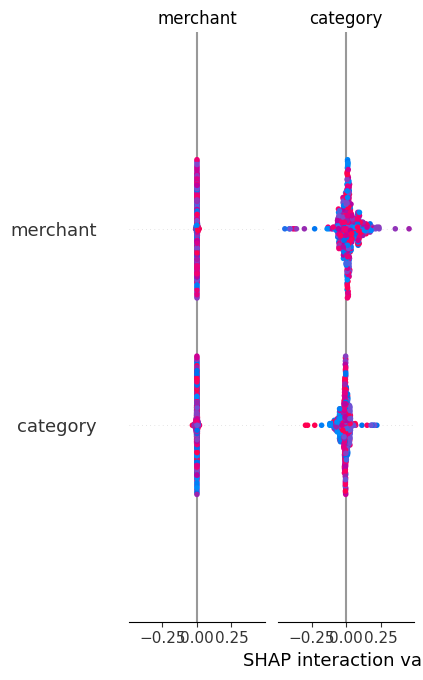

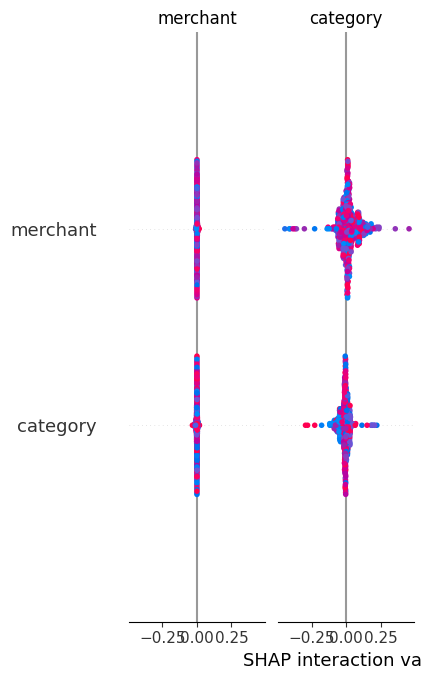

2025/10/05 21:30:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/05 21:31:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [35]:
#SHAP Explanations
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test, plot_type="bar")
#shap.summary_plot(shap_values, X_test)
#plt.show()



#Sampling subsets as it take resources
X_shap = X_test.sample(n=500, random_state=42)

#Create SHAP explainer and compute SHAP values on subset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

#Plotting
shap.summary_plot(shap_values, X_shap, plot_type="bar")
plt.savefig('shap_bar_rf.png')
#plt.show()
plt.close()
shap.summary_plot(shap_values, X_shap)
plt.savefig('shap_summary_rf.png')
#plt.show()
plt.close()

# Log model
mlflow.sklearn.log_model(model, "rf_model")

   





In [36]:
# Step 16: Print 10 sample predictions
sample_indices = random.sample(range(len(X_test)), 10)
for i in sample_indices:
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}")

Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0


In [37]:
mlflow.end_run()